---

#**PART 1: Regression Analysis**

---

In [ ]:
import os
import requests
import zipfile

# URL of the dataset
url = "https://raw.githubusercontent.com/oooshwin/casestudy1/main/BrentOilPrices.zip"
zip_file = "/BrentOilPrices.zip"
extract_dir = "/content/BrentOilPrices"

# Download the zip file
response = requests.get(url)
with open(zip_file, 'wb') as f:
    f.write(response.content)

# Unzip the file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
import pandas as pd

# File path
file_path = "/content/BrentOilPrices/BrentOilPrices.csv"

# Load the data into a pandas DataFrame
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

# Display the first few rows of the DataFrame
# df.head(20)

<ipython-input-58-38af06549750>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")



---

#**Preprocess data according to window size, resolution and overlap**


---



In [ ]:
#  preprocess data according to window size, resolution and overlap
def preprocess_data(df, column_name, window_size, overlap=3, resolution=None):

    # Resample based on resolution
    if resolution == "daily":
        df = df.resample("D").mean()
    elif resolution == "weekly":
        df = df.resample("W").mean()
    elif resolution == "monthly":
        df = df.resample("M").mean()

    df = df.dropna()

    # Extract relevant series
    series = df[column_name].values
    X, y = [], []

    # overlapping windows
    for i in range(0, len(series) - window_size, overlap):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])

    return np.array(X), np.array(y)



---
#**DATASET HYPERPARAMETERS**

---



In [ ]:
# hyperparamters (play around these)
import numpy as np

window_size = 20
overlap = 2
resolution = "weekly"
# preprocess the dataset
X, y = preprocess_data(df, column_name="Price", window_size=window_size, overlap=overlap, resolution=resolution)




---

#**SPLIT**

---



In [ ]:
# Split data
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]



---

#**Testing against Random Forest Classifier**

---



Mean Squared Error (Random Forest): 11.2230


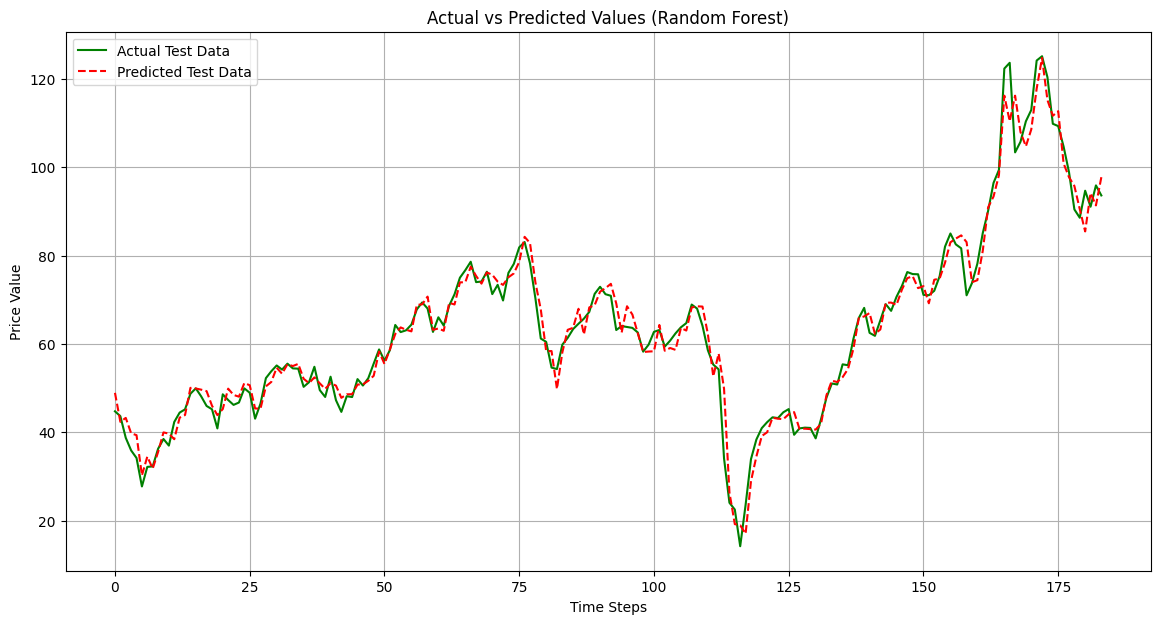

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
#  Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Calculate Mean Squared Error
mse_rf = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (Random Forest): {mse_rf:.4f}")

# Plot Actual vs Predicted Values
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_test)), y_test, label='Actual Test Data', color='green')
plt.plot(range(len(y_test)), y_pred, label='Predicted Test Data', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Price Value')
plt.title('Actual vs Predicted Values (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()




---

#**TESTING AGAINST NEURAL NETWORK**

---





Epoch [1/100], Loss: 1831.2741
Epoch [2/100], Loss: 108.1218
Epoch [3/100], Loss: 68.4706
Epoch [4/100], Loss: 61.3290
Epoch [5/100], Loss: 57.7425
Epoch [6/100], Loss: 52.7002
Epoch [7/100], Loss: 48.3530
Epoch [8/100], Loss: 40.8489
Epoch [9/100], Loss: 34.2849
Epoch [10/100], Loss: 27.3419
Epoch [11/100], Loss: 21.8584
Epoch [12/100], Loss: 17.6549
Epoch [13/100], Loss: 14.6432
Epoch [14/100], Loss: 13.4503
Epoch [15/100], Loss: 11.7944
Epoch [16/100], Loss: 11.4398
Epoch [17/100], Loss: 10.9383
Epoch [18/100], Loss: 10.5903
Epoch [19/100], Loss: 10.5539
Epoch [20/100], Loss: 9.7027
Epoch [21/100], Loss: 9.7621
Epoch [22/100], Loss: 10.3584
Epoch [23/100], Loss: 9.7240
Epoch [24/100], Loss: 9.3663
Epoch [25/100], Loss: 9.6190
Epoch [26/100], Loss: 8.6062
Epoch [27/100], Loss: 8.3054
Epoch [28/100], Loss: 8.1501
Epoch [29/100], Loss: 7.9761
Epoch [30/100], Loss: 8.5031
Epoch [31/100], Loss: 8.6034
Epoch [32/100], Loss: 7.8553
Epoch [33/100], Loss: 7.9066
Epoch [34/100], Loss: 7.3706


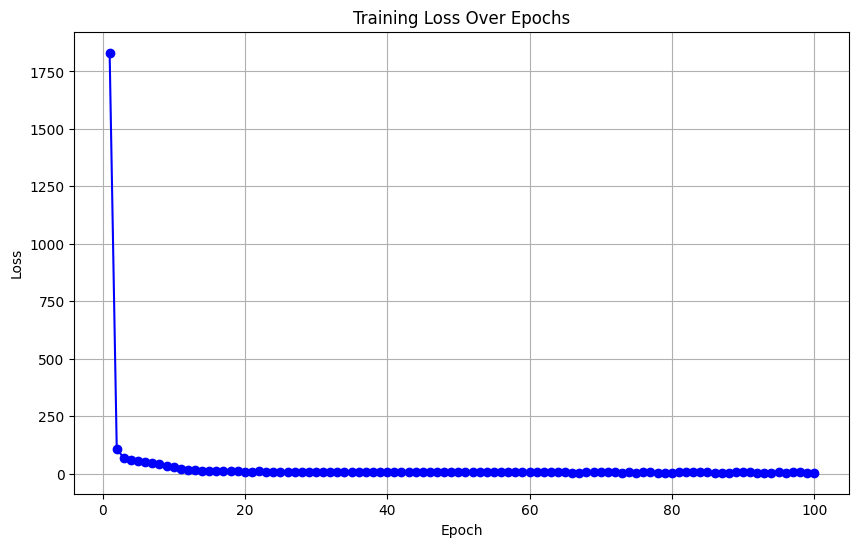

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# Define PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create DataLoaders
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Neural Network Model
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

# Initialize model, loss, and optimizer
input_size = window_size
model = RegressionModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
loss_values = []
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

model.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze()
        y_pred_list.extend(y_pred.numpy())
        y_true_list.extend(y_batch.numpy())

# Calculate Mean Squared Error
mse_pytorch = mean_squared_error(y_true_list, y_pred_list)
print(f"Mean Squared Error (Neural Network): {mse_pytorch:.4f}")

# Plot Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()




---

#**PART 2: CLASSIFICATION ANALYSIS**

---



In [ ]:
# File path
# file_path = "/content/BrentOilPrices/BrentOilPrices.csv"

# # Load the data into a pandas DataFrame
# df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
!pip install ta #technical analysis library

from ta.momentum import RSIIndicator
from ta.trend import MACD


# technical indicators
df['RSI'] = RSIIndicator(df['Price'], window=20).rsi() # play around window
macd_indicator = MACD(df['Price'])
df['MACD'] = macd_indicator.macd()
df['MACD_Signal'] = macd_indicator.macd_signal()

# classify
def classify(row):
    if row['RSI'] < 50 and row['MACD'] > row['MACD_Signal']:
        return 0  # buy
    elif row['RSI'] > 50 and row['MACD'] < row['MACD_Signal']:
        return 1  # sell
    else:
        return 2  # hold


df['Action'] = df.apply(classify, axis=1)
df.dropna()
# df.head()

# print("action counts:")
print(df['Action'].value_counts())

Action
2    6127
1    1595
0    1289
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Features and target
features = ['Price', 'RSI', 'MACD', 'MACD_Signal', ]
X = df[features]
y = df['Action']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=41)
df_predictions = X_test.copy()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions) * 100

invest = 100
print( f'Initial Investment: {invest}')
idx = 0
for num in X_test['Price'].values:
  if predictions[idx] == 0:
    invest -= num
  elif predictions[idx] == 1:
    invest += num
  idx += 1
print(f'Earnings at the end: {invest:.2f}')

print(f"Random Forest: {accuracy:.2f}%")
print(df_predictions.head())

Initial Investment: 100
Earnings at the end: 8459.10
Random Forest: 96.06%
             Price        RSI      MACD  MACD_Signal
Date                                                
1987-09-29   18.50  48.654357 -0.016660    -0.095540
2016-01-19   27.36  21.977851 -3.066305    -2.623463
1989-02-16   17.15  56.687290  0.053117     0.093219
2013-01-30  115.42  61.823797  1.099931     0.817736
2002-09-26   28.93  58.659931  0.551404     0.526714
